# Generative Models

This notebook gives a quick example on how to build a denoising UNet by creating a custom model and layers.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import tensorflow as tf

from deepsphere import HealpyGCNN
from deepsphere import healpy_layers as hp_layer
from deepsphere import utils

from tqdm import tqdm

2024-04-01 19:09:22.097765: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-01 19:09:22.123652: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 19:09:22.123690: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 19:09:22.123704: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-01 19:09:22.130889: I tensorflow/core/platform/cpu_feature_g

## 1 Data loading

The data consists of a toy dataset that is sufficiently small to have fun with.
It is made of 200 maps of size `nside=64` splitted in 2 classes. 

The maps contain Gaussian random field realisations produced by the `synfast` function from `healpy`.
The input power spectra were taken from a ΛCDM model with two sets of parameters.
These maps are not realistic cosmological mass maps, just a toy dataset.
We downsampled them to `nside=64` to make processing faster.

In [2]:
data = np.load('../data/maps_downsampled_64.npz')
assert(len(data['class1']) == len(data['class2']))
nclass = len(data['class1'])

We only need the first class in this notebook. Further, we will smooth the data a bit.

In [3]:
training_data = []
for m in data['class1']:
    m = hp.reorder(m, n2r=True)
    m = hp.smoothing(m, fwhm=.05, verbose=False)
    m = hp.reorder(m, r2n=True)
    training_data.append(100*m.astype(np.float32)[:,None])
training_data = np.array(training_data)

/tmp/ipykernel_18534/1919380410.py:4: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  m = hp.smoothing(m, fwhm=.05, verbose=False)


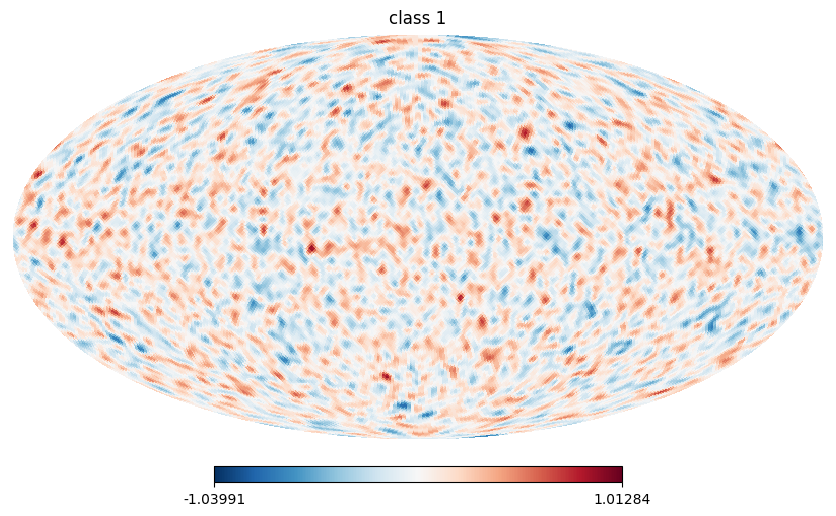

In [4]:
cmin = np.min(training_data)
cmax = np.max(training_data)
cm = plt.cm.RdBu_r
hp.mollview(training_data[0,:,0], title='class 1', nest=True, cmap=cm, min=cmin, max=cmax)

## 2 A UNet custom model

We implement a UNet and the blocks to decrease or increase the nside.

In [5]:
class UNetLayerDown(tf.keras.Model):
    def __init__(self, nside, indices, Fout, K=5):
        """
        Inits a layer that reduces the nside of the input, can be used in a UNet
        """
    
        # this line is necessary for all Model subclasses
        super().__init__(name="")

        # attributes
        self.nside = nside
        self.indices = indices

        # init the network
        layers = [hp_layer.HealpyPseudoConv(p=1, Fout=Fout, activation="elu"),
                  hp_layer.HealpyChebyshev(K=K, Fout=Fout, use_bias=True, use_bn=False, activation="elu"),
                  tf.keras.layers.LayerNormalization(axis=1),
                 ]
        self.gcnn = HealpyGCNN(nside=nside, 
                               indices=indices,
                               layers=layers
                              )

    def call(self, input_tensor, training=False, *args, **kwargs):
        """
        Calls the block
        """

        output = self.gcnn(input_tensor, training=training, *args, **kwargs)
        return output

class UNetLayerUp(tf.keras.Model):
    def __init__(self, nside, indices, Fout, K=5):
        """
        Inits a layer that increases the nside of the input, can be used in a UNet
        """
    
        # this line is necessary for all Model subclasses
        super().__init__(name="")

        # attributes
        self.nside = nside
        self.indices = indices

        # init the network
        layers = [hp_layer.HealpyChebyshev(K=K, Fout=Fout, use_bias=True, use_bn=False, activation="elu"),
                  tf.keras.layers.LayerNormalization(axis=1),
                  hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=Fout, activation="elu"),
                 ]
        self.gcnn = HealpyGCNN(nside=nside, 
                               indices=indices,
                               layers=layers
                              )

    def call(self, input_tensor, training=False, *args, **kwargs):
        """
        Calls the block
        """

        output = self.gcnn(input_tensor, training=training, *args, **kwargs)
        return output

class HealpyUNet(tf.keras.Model):
    def __init__(self, nside, indices, n_blocks=3, channel_fac=2, output_channels=1):
        """
        Inits the Unet with a given number of blocks 
        """

        # this line is necessary for all Model subclasses
        super().__init__(name="")

        # attributes
        self.nside = nside
        self.indices = indices
        self.n_blocks = n_blocks
        self.channel_fac = channel_fac
        self.output_channels = output_channels
        self.up_layers = []
        self.down_layers = []

        # the down blocks
        Fout = 4
        self.block_indices = []
        self.block_nsides = []
        for i in range(n_blocks):
            down_layer = UNetLayerDown(nside=nside, indices=indices, Fout=Fout)
            indices = down_layer.gcnn._transform_indices(nside_in=nside,
                                                         nside_out=nside//2,
                                                         indices=indices)

            # append
            self.block_indices.append(indices)
            self.block_nsides.append(nside)
            self.down_layers.append(down_layer)

            # update
            nside = nside // 2
            Fout = channel_fac*Fout

        # the up layers
        for i in reversed(range(n_blocks)):
            nside = self.block_nsides[i]
            indices = self.block_indices[i]
            Fout = Fout//channel_fac
            up_layer = UNetLayerUp(nside=nside, indices=indices, Fout=Fout)
            
            # append
            self.up_layers.append(up_layer)

        # the final projection
        self.final_layer = tf.keras.layers.Conv1D(filters=output_channels, kernel_size=1)
        

    def call(self, input_tensor, training=False, *args, **kwargs):
        """
        Calls the UNet
        """

        down_output = []
        for down_layer in self.down_layers:
            input_tensor = down_layer(input_tensor, training=False, *args, **kwargs)
            down_output.append(input_tensor)

        # for the first layer nothing happens we just go up again
        input_tensor = down_output.pop(-1)
        first_layer = self.up_layers[0]
        input_tensor = first_layer(input_tensor, training=False, *args, **kwargs)

        # we concat and up cycle
        for up_layer, d_out in zip(self.up_layers[1:], reversed(down_output)):
            input_tensor = tf.concat([input_tensor, d_out], axis=-1)
            input_tensor = up_layer(input_tensor, training=False, *args, **kwargs)

        # the final layer
        input_tensor = self.final_layer(input_tensor, training=False, *args, **kwargs)
        
        return input_tensor

We initialize the model.

In [6]:
nside = 64
n_pix = hp.nside2npix(nside)
indices = np.arange(n_pix)
model = HealpyUNet(nside, indices)
model.build(input_shape=(None, len(indices), 1))
model.summary(110)

Detected a reduction factor of 2.0, the input with nside 64 will be transformed to 32 during a forward pass. Checking for consistency with indices...
indices seem consistent...


2024-04-01 19:09:24.949553: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-01 19:09:24.975962: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Detected a reduction factor of 2.0, the input with nside 32 will be transformed to 16 during a forward pass. Checking for consistency with indices...
indices seem consistent...
Detected a reduction factor of 2.0, the input with nside 16 will be transformed to 8 during a forward pass. Checking for consistency with indices...
indices seem consistent...
Detected a reduction factor of 0.5, the input with nside 16 will be transformed to 32 during a forward pass. Checking for consistency with indices...
indices seem consistent...
Detected a reduction factor of 0.5, the input with nside 32 will be transformed to 64 during a forward pass. Checking for consistency with indices...
indices seem consistent...
Detected a reduction factor of 0.5, the input with nside 64 will be transformed to 128 during a forward pass. Checking for consistency with indices...
indices seem consistent...
Model: ""
_________________________________________________________________________________________________________

Note that for this simple toy model we chose a bottleneck that is only 8 times smaller than the input data.

## 3 Training the model

We use again the `model.compile()` and `model.fit()` routines to train the model. Note that we leave out a training and validation data split.

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
              loss="MAE",
              metrics=["MAE"],
)

Select the noise that should be added for the training data.

In [8]:
noise_std = 0.25
np.random.seed(11)
noise_data = training_data + np.random.normal(size=training_data.shape).astype(np.float32)*noise_std
print("Fit model on training data")
history = model.fit(
    x=noise_data[1:],
    y=training_data[1:],
    batch_size=5,
    epochs=50,
)

Fit model on training data
Epoch 1/50
20/20 [==============================] - 5s 95ms/step - loss: 0.1585 - MAE: 0.1585
Epoch 2/50
20/20 [==============================] - 2s 111ms/step - loss: 0.0982 - MAE: 0.0982
Epoch 3/50
20/20 [==============================] - 2s 111ms/step - loss: 0.0920 - MAE: 0.0920
Epoch 4/50
20/20 [==============================] - 2s 109ms/step - loss: 0.0887 - MAE: 0.0887
Epoch 5/50
20/20 [==============================] - 2s 109ms/step - loss: 0.0869 - MAE: 0.0869
Epoch 6/50
20/20 [==============================] - 2s 107ms/step - loss: 0.0857 - MAE: 0.0857
Epoch 7/50
20/20 [==============================] - 2s 107ms/step - loss: 0.0840 - MAE: 0.0840
Epoch 8/50
20/20 [==============================] - 2s 103ms/step - loss: 0.0825 - MAE: 0.0825
Epoch 9/50
20/20 [==============================] - 2s 103ms/step - loss: 0.0814 - MAE: 0.0814
Epoch 10/50
20/20 [==============================] - 2s 104ms/step - loss: 0.0806 - MAE: 0.0806
Epoch 11/50
20/20 [====

Let's have a look at a reconstructed image.

In [9]:
original_map = training_data[:1]
noisy_map = noise_data[:1]
reconstructed_map = model(noisy_map, True).numpy()

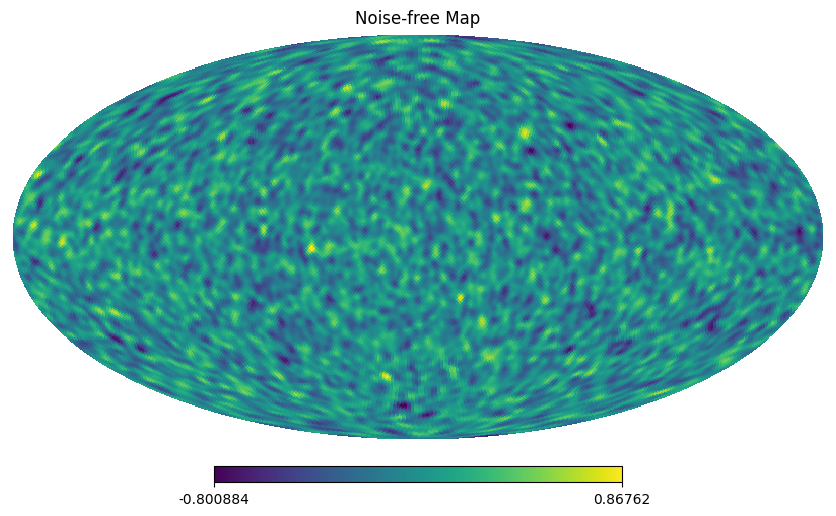

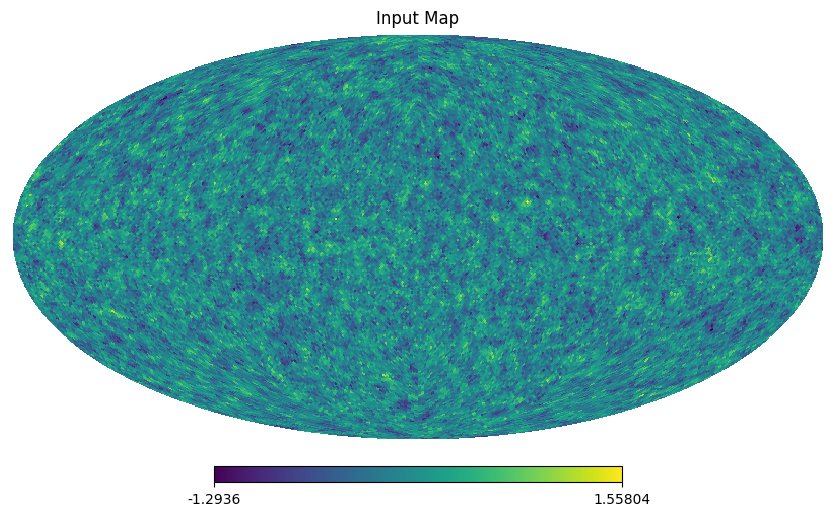

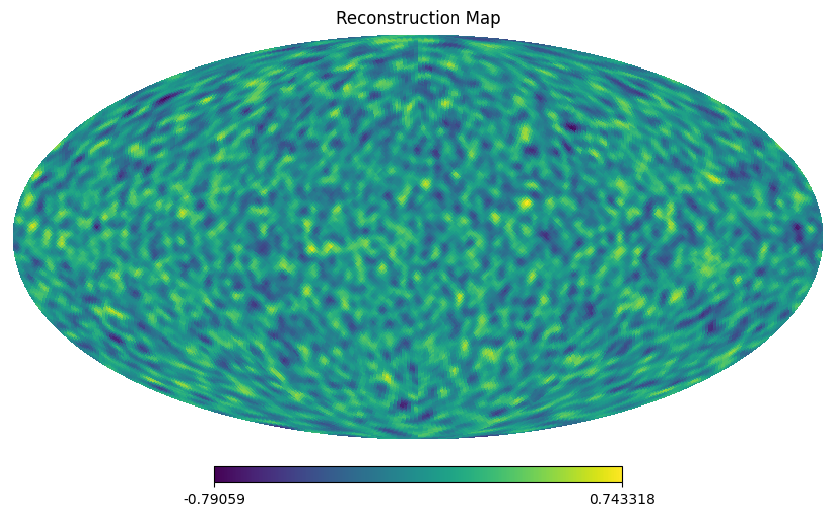

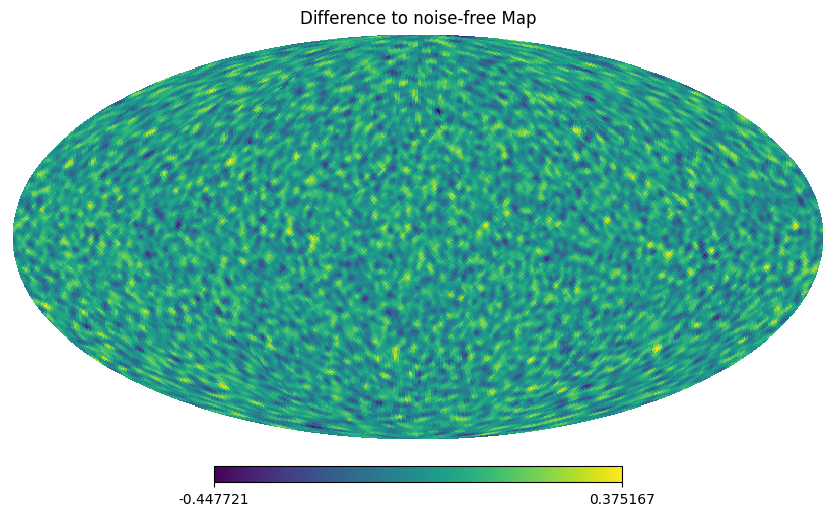

In [10]:
hp.mollview(original_map[0,:,0], nest=True, title="Noise-free Map")
hp.mollview(noisy_map[0,:,0], nest=True, title="Input Map")
hp.mollview(reconstructed_map[0,:,0], nest=True, title="Reconstruction Map")
hp.mollview(original_map[0,:,0] - reconstructed_map[0,:,0], nest=True, title="Difference to noise-free Map")

Let's take a look at the loss during training.

Text(0, 0.5, 'Loss')

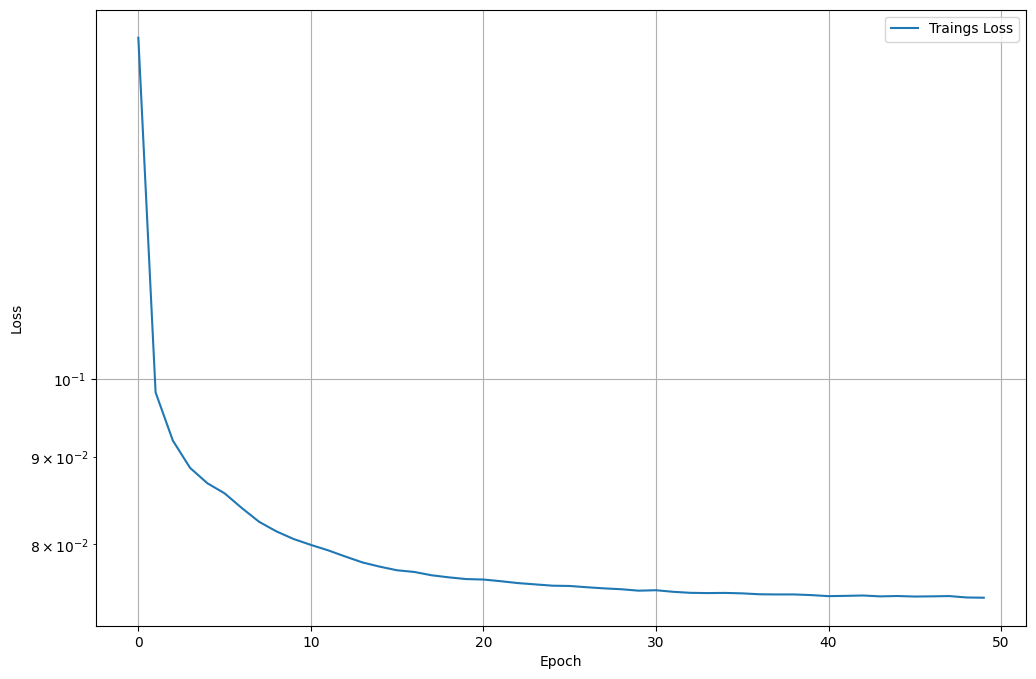

In [11]:
plt.figure(figsize=(12,8))
plt.plot(history.history["loss"], label="Traings Loss")
plt.grid()
plt.yscale("log")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")